## Exploration of Word Embeddings in the Context of Covid-19 Document Classification
### Imports
(TODO: shortly explain each of the paragraphs/steps)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Load the Abstracts
Use the cleaned abstracts in the `train.csv` file to avoid redundant preprocessing.

In [64]:
data = pd.read_csv("../data/document_classification/train.csv", sep = "\t")

# group data by different categories
groups = [g["text"] for _,g in data.groupby(["Categories"])]
category_names = [g.iloc[0]["Categories"] for _,g in data.groupby(["Categories"])]

### Load the Results from the Document Classificaiton

In [65]:
def average_metrics(path, ranges, shp):
    reports = np.empty(shape=shp)

    # add the results of the reports
    for i in range(len(ranges)):
        report = pd.read_csv(path + "classification_report.txt", 
                             skiprows=lambda x: x < ranges[i][0] or x > ranges[i][1], sep="\s{2,}", index_col=0)
        reports[i,:,:] = report.values

    # calculate the average of the metrics
    means = np.mean(reports, axis=0)
    stds = np.std(reports, axis=0)

    # save means and stds per metric per class
    final_report = pd.DataFrame(index=report.index, columns=report.columns.values)
    for i in range(len(report.columns.values)-1):
        final_report.iloc[:,i] = [str(round(i,3)) + "±" + str(round(j,3)) for i,j in zip(means[:,i],stds[:,i])]

    final_report["support"] = np.sum(reports, axis=0)[:,-1].astype(int)

    return final_report

bert_style_ranges = [(1,12), (16,27), (31,42), (46,57), (61,72)]
bert_shape = (5,9,4)
doc2vec_ranges = [(1,11), (15,25), (29,39), (43,53), (57,67)]
doc2vec_shape = (5,8,4)

average_bert = average_metrics("./saved_models/covid-classification-best-model-06222020-13:16:29/", 
                              bert_style_ranges, bert_shape)
average_biobert = average_metrics("./saved_models/covid-classification-best-model-06222020-16:08:56/",
                                 bert_style_ranges, bert_shape)
average_covidbert = average_metrics("./saved_models/covid-classification-best-model-06222020-17:12:30/",
                                   bert_style_ranges, bert_shape)
average_doc2vec = average_metrics("./saved_models/covid-doc2vec/", doc2vec_ranges, doc2vec_shape)

averages = [average_bert, average_biobert, average_covidbert, average_doc2vec]
model_names = ["BERT", "BioBERT", "CovidBERT", "Doc2Vec"]

print(average_doc2vec)

                precision       recall     f1-score              support
Case Report   0.568±0.042  0.496±0.066  0.528±0.052                  297
Diagnosis     0.592±0.039  0.504±0.029  0.544±0.029                  904
Mechanism     0.436±0.051  0.366±0.048  0.398±0.047                  495
Prevention    0.786±0.028  0.872±0.017  0.828±0.021                 2216
Treatment     0.628±0.026  0.622±0.057  0.626±0.036                 1356
accuracy      0.676±0.027  1053.6±0.49      nan±nan -9223372036854775808
macro avg     0.602±0.029  0.572±0.032   0.586±0.03                 5268
weighted avg  0.666±0.027  0.676±0.027   0.67±0.028                 5268


/home/hbalabin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


### Visualize the Results

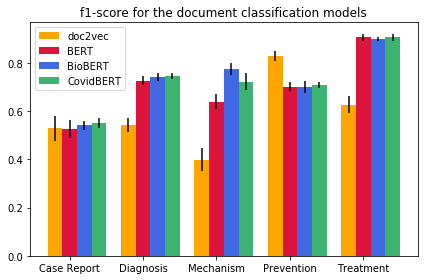

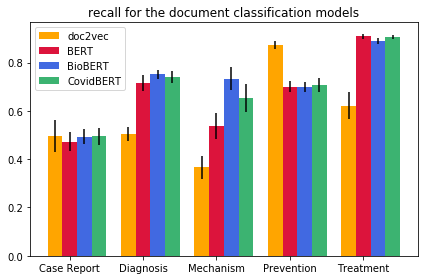

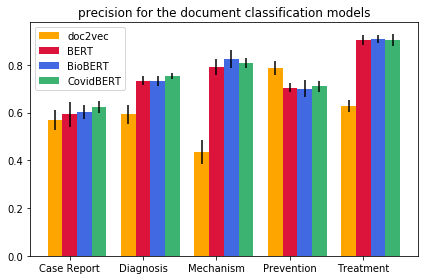

In [52]:
def visualize(metric):
    x = np.arange(len(category_names)
                 ) # the x locations for the groups
    width = 0.35         # the width of the bars

    av_doc2vec = [(float(i.split("±")[0]),float(i.split("±")[1])) for i in average_doc2vec.iloc[:5][metric]]
    av_bert = [(float(i.split("±")[0]),float(i.split("±")[1])) for i in average_bert.iloc[:5][metric]]
    av_biobert = [(float(i.split("±")[0]),float(i.split("±")[1])) for i in average_biobert.iloc[:5][metric]]
    av_covidbert = [(float(i.split("±")[0]),float(i.split("±")[1])) for i in average_covidbert.iloc[:5][metric]]

    ax = plt.subplot(111)
    ax.bar(x-0.2, [i[0] for i in av_doc2vec], width=0.2, color='orange', align='center', 
           yerr=[i[1] for i in av_doc2vec], label="doc2vec")
    ax.bar(x, [i[0] for i in av_bert], width=0.2, color='crimson', align='center', 
           yerr=[i[1] for i in av_bert], label="BERT")
    ax.bar(x+0.2, [i[0] for i in av_biobert], width=0.2, color='royalblue', align='center', 
           yerr=[i[1] for i in av_biobert], label="BioBERT")
    ax.bar(x+0.4, [i[0] for i in av_covidbert], width=0.2, color='mediumseagreen', align='center', 
           yerr=[i[1] for i in av_covidbert], label="CovidBERT")

    ax.set_title(metric + " for the document classification models")
    ax.legend()
    
    plt.tight_layout()
    plt.xticks(x, ["Case Report", "Diagnosis", "Mechanism", "Prevention", "Treatment"])
    # plt.savefig("../data/visualization/" + metric + "-document-classification-results.png")
    plt.show() 
    
visualize("f1-score")
visualize("recall")
visualize("precision")

### Extracting the Most Frequent Unigrams in the Text, Grouped by Category

In [67]:
def create_ngrams(abstract_texts, min_occ):
    vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r'\S+')
    text_ngrams = vectorizer.fit_transform(abstract_texts)
    features = vectorizer.get_feature_names()

    vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r'\S+') # You can still specify n-grams here.
    ngrams_tfidf = vectorizer.fit_transform(abstract_texts)
    
    # Getting top ranking features 
    sums = ngrams_tfidf.sum(axis = 0)
    sums2 = text_ngrams.sum(axis = 0)
    data = [] 
    for col, term in enumerate(features): 
        data.append((term, sums2[0,col], sums[0,col])) 
    ranking = pd.DataFrame(data, columns = ['unigrams','frequency', 'rank_tf-idf']) 
    ranking['relative_frequency'] = ranking['frequency'] / ranking['frequency'].sum()
    # rank by tf-idf
    words = (ranking.sort_values('rank_tf-idf', ascending = False)) 
    # prune those that only appear once. alternatively, select all those under a certain tf-idf
    words = words[words.frequency >= min_occ]
    # just swap so that tf-idf is at the end...
    words = words[['unigrams','frequency', 'relative_frequency', 'rank_tf-idf']]
    
    # print("\n\n")
    # print(words[:25])
    
    return words


most_common_terms = [create_ngrams(g, 5) for g in groups]
common_unigrams = set(most_common_terms[0]["unigrams"])

for i in most_common_terms[1:]:
    common_unigrams = all_unigrams.intersection(i["unigrams"])

# lets take 10 words in each list that are not in the other ones 
unique_unigrams = [[i for i in j["unigrams"] if i not in common_unigrams] for j in most_common_terms]
print([i[:25] for i in unique_unigrams])

[['transplant', 'recipient', 'man', 'stroke', 'surgery', 'ground-glass', 'hiv', 'surgical', 'coronary', 'hydroxychloroquine', 'ecmo', 'discharge', 'x-ray', 'healthcare', 'hour', "patient's", 'hemodialysis', 'supportive', 'thrombosis', 'facility', 'artery', 'procedure', 'covid', 'managed', 'cesarean'], ['ci', 'sensitivity', 'model', 'igg', 'igm', 'image', 'consolidation', 'specificity', 'prevalence', 'cohort', 'performance', 'mean', 'healthcare', 'difference', 'ground-glass', 'lobe', 'crp', 'tool', 'distribution', 'ultrasound', 'anosmia', 'ggo', 'p0001', 'smell', 'enrolled'], ['ace2', 'sequence', 'host', 'coronaviruses', 'genome', 'bat', 'vaccine', 'spike', 'animal', 'expression', 'cov', 'structure', 'binding', 'mers-cov', 'mutation', 'pathogenesis', 'mers', 'model', 'covs', 'interaction', 'rbd', 'domain', 'activity', 'east', 'enzyme'], ['healthcare', 'surgery', 'practice', 'service', 'procedure', 'surgical', 'recommendation', 'model', 'guideline', 'equipment', 'personal', 'lockdown', '

### Load the Trained Models and Obtaining the Embeddings of the Unigrams

### t-SNE Visualization 